In [1]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseTransformer, self_columns, reset_columns

from source.impute import DfImputer

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

In [2]:
df_train = pd.read_csv('data/train.csv')
train, test = tml.make_test(df_train, test_size=0.25, random_state=43, strat_feat=['Pclass', 'Sex'])
kfolds = KFold(n_splits=10, random_state=235, shuffle=True)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24665,24665,0,3,"Jones, Rhett",male,44.0,0,0,25604,25.17,NaN,S
67933,67933,0,3,"Twomey, Paul",male,27.0,0,0,478284,11.53,NaN,S
41148,41148,0,3,"Brady, Amy",female,7.0,1,1,10375,80.13,NaN,S
49460,49460,0,3,"Shealy, William",male,37.0,0,0,C 15695,7.69,NaN,S
69515,69515,0,1,"Kolb, Willie",male,65.0,1,1,23480,77.39,C6991,C


# Baseline

In [4]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), 
                      ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=8, random_state=657))])

In [5]:
train_cols = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [6]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True, imp_coef=True)

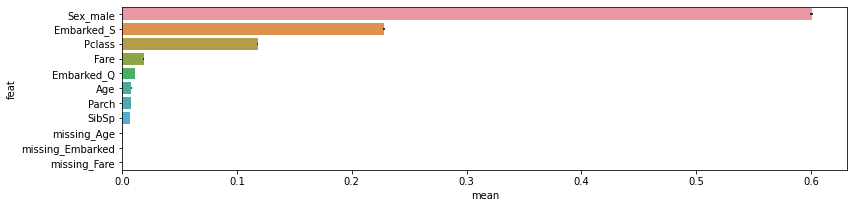

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


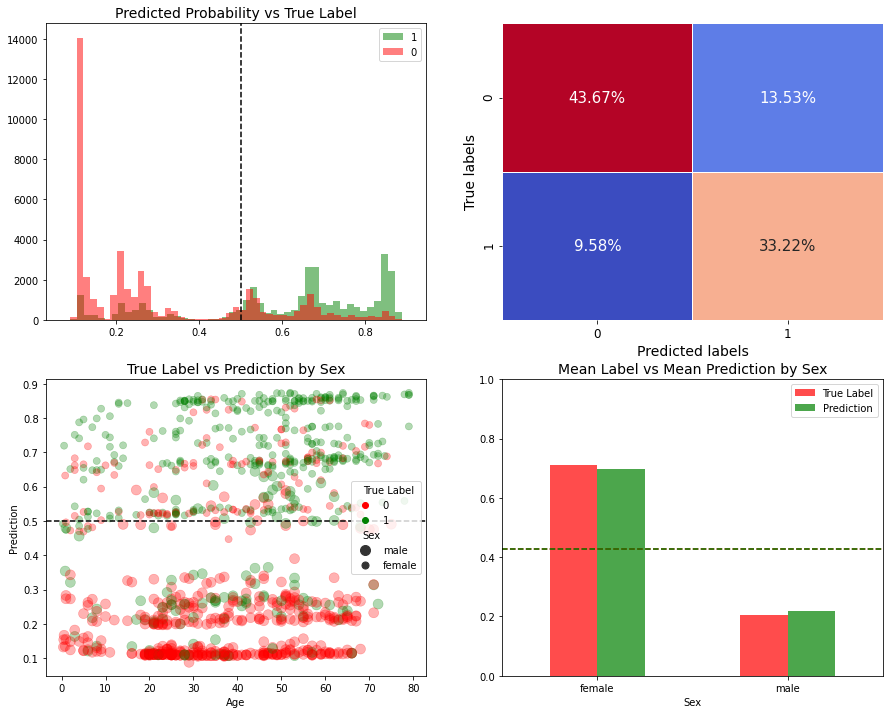

Accuracy score: 	0.769
AUC ROC: 		0.8361
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     42902
           1       0.71      0.78      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


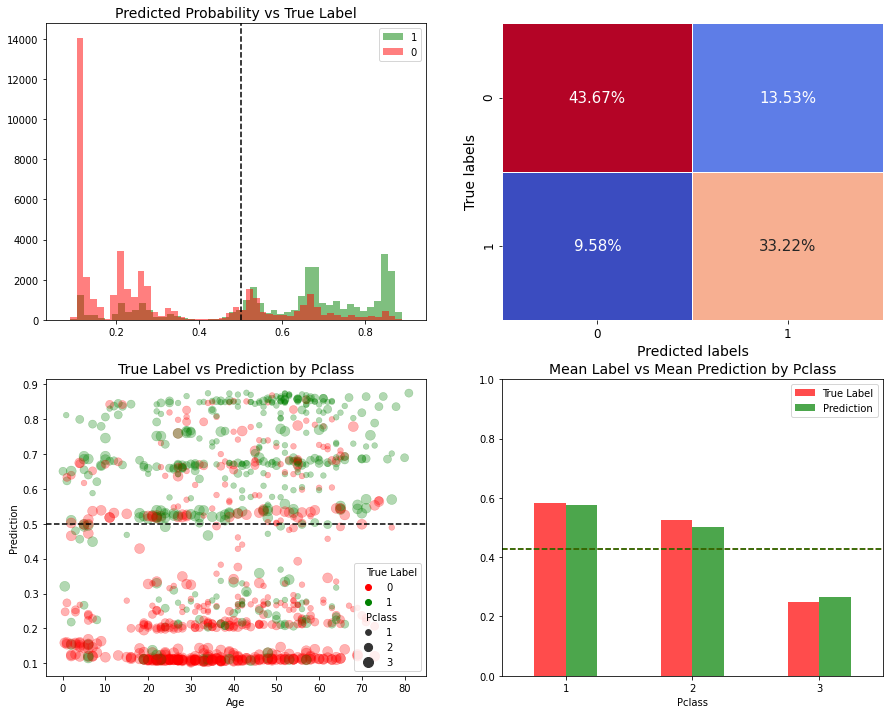

In [7]:
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')

# Tuned baseline

In [8]:
grid_params = {'tree__max_depth': [3, 5, 8, 16], 
               'tree__min_samples_split': [2, 4, 8, 16], 
               'tree__max_features': ['auto', None]}

res, bp, be = tml.grid_search(data=train[train_cols], target=train.Survived, estimator=full_pipe, param_grid=grid_params, cv=kfolds, scoring='accuracy')

res

,param_tree__max_depth,param_tree__max_features,param_tree__min_samples_split,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,16,auto,16,0.788572,0.000930,0.770493,0.005229,29.642685,1.120802,1.407198,0.086087
1,16,auto,8,0.794559,0.001030,0.769947,0.005332,30.632153,0.856593,1.442253,0.145925
2,16,auto,4,0.801544,0.000952,0.769907,0.005288,30.928416,0.459327,1.411683,0.118199
3,8,None,8,0.774270,0.000559,0.769773,0.004682,41.509413,0.776368,1.065248,0.071980
4,8,None,16,0.774056,0.000588,0.769667,0.004699,41.075590,0.442343,0.970656,0.083655
5,8,None,2,0.774575,0.000558,0.769613,0.004869,43.272997,1.276484,1.057999,0.110444
6,8,None,4,0.774455,0.000624,0.769573,0.004795,41.358128,0.530676,1.063353,0.073232
7,16,None,16,0.803579,0.000859,0.769453,0.006199,50.286600,6.021609,1.463406,0.270109
8,8,auto,2,0.771206,0.000614,0.768960,0.004896,20.771721,0.763866,0.956456,0.142843
9,16,auto,2,0.809671,0.001097,0.768867,0.005636,31.231653,1.415014,1.469633,0.159039


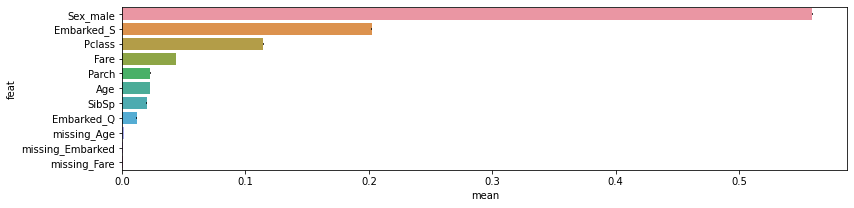

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


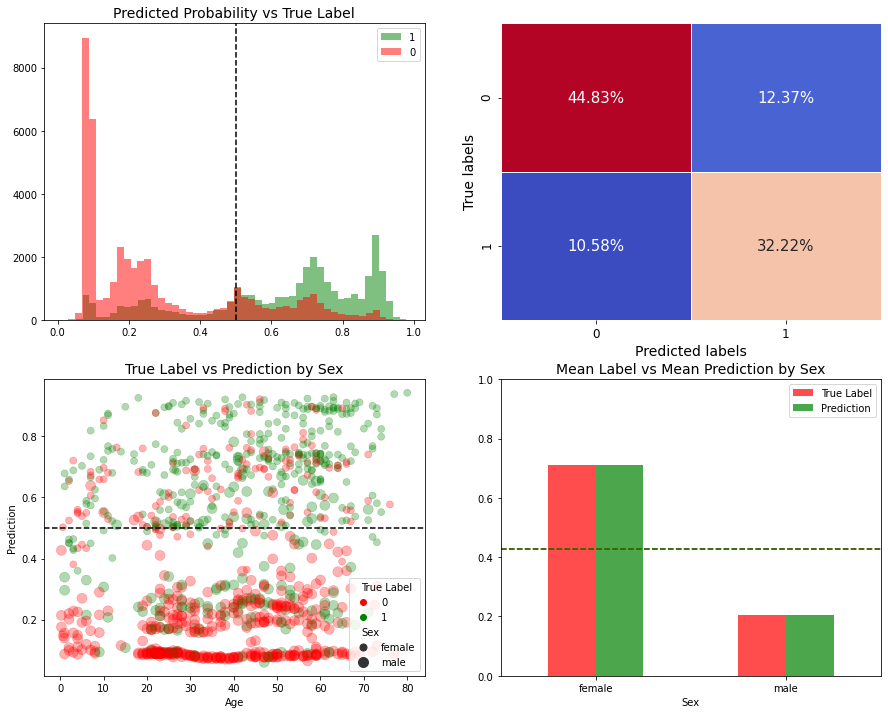

Accuracy score: 	0.7705
AUC ROC: 		0.8407
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     42902
           1       0.72      0.75      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


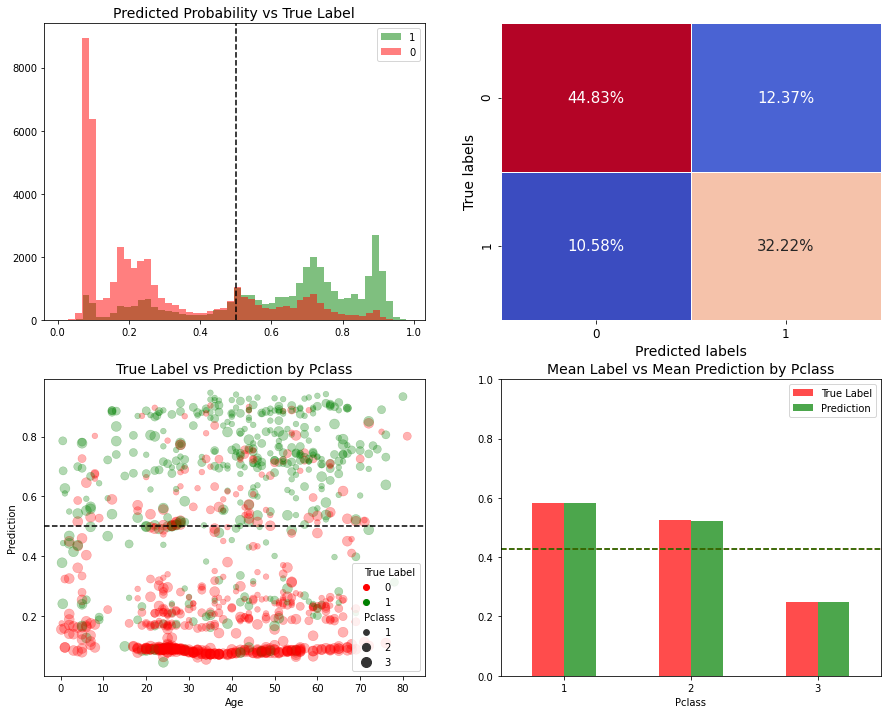

In [9]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=be, cv=kfolds, predict_proba=True, imp_coef=True)
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')

# Interactions

In [10]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), ('int', tml.DfPolynomial()),
                      ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=16, min_samples_split=16))])

In [11]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True, imp_coef=True)

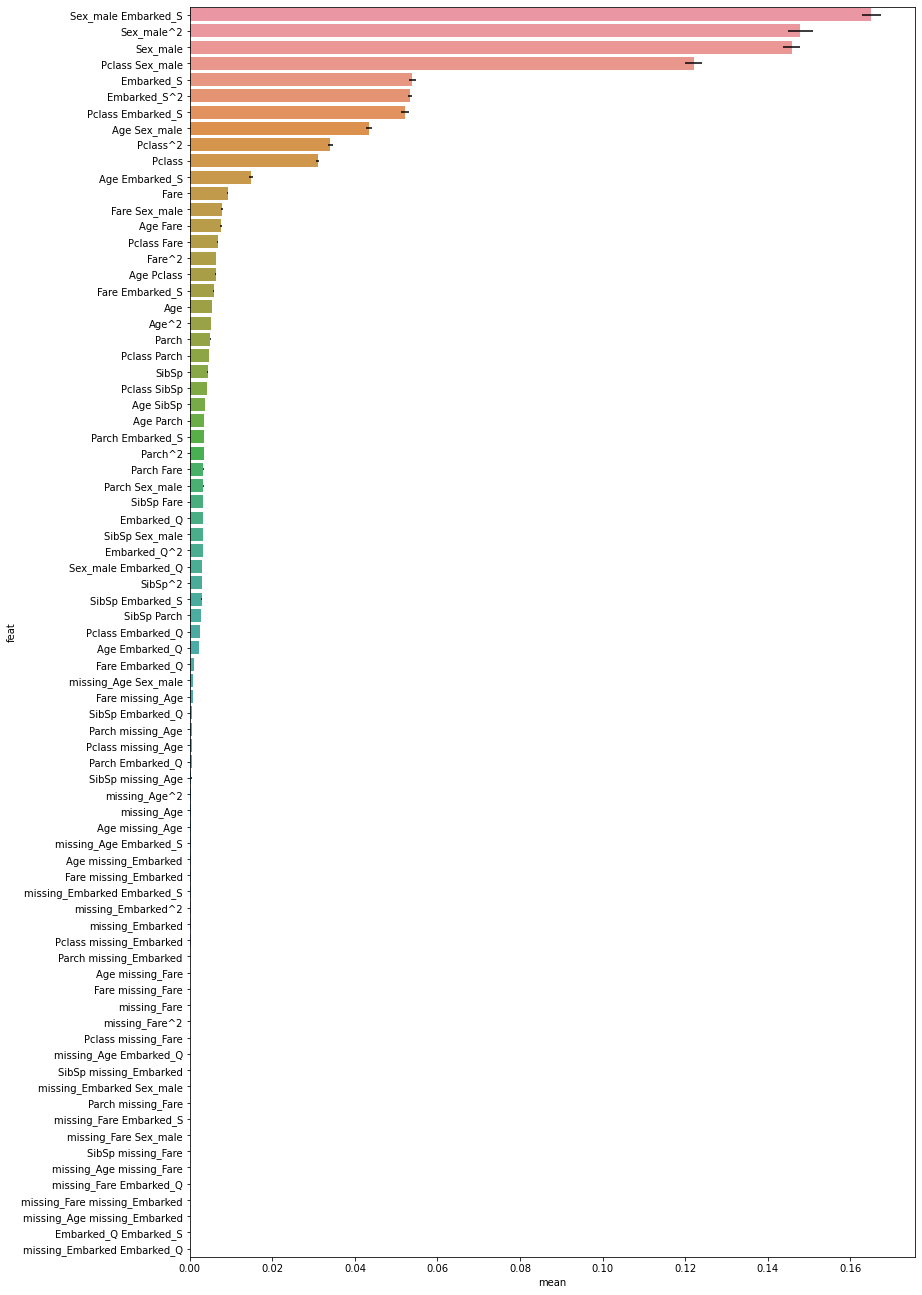

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


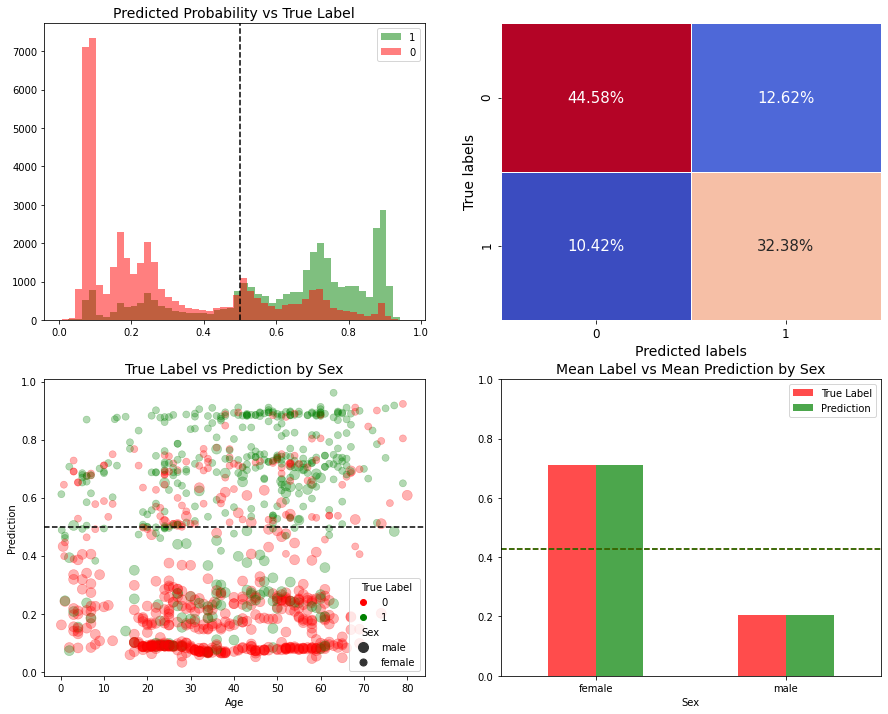

Accuracy score: 	0.7696
AUC ROC: 		0.8405
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     42902
           1       0.72      0.76      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


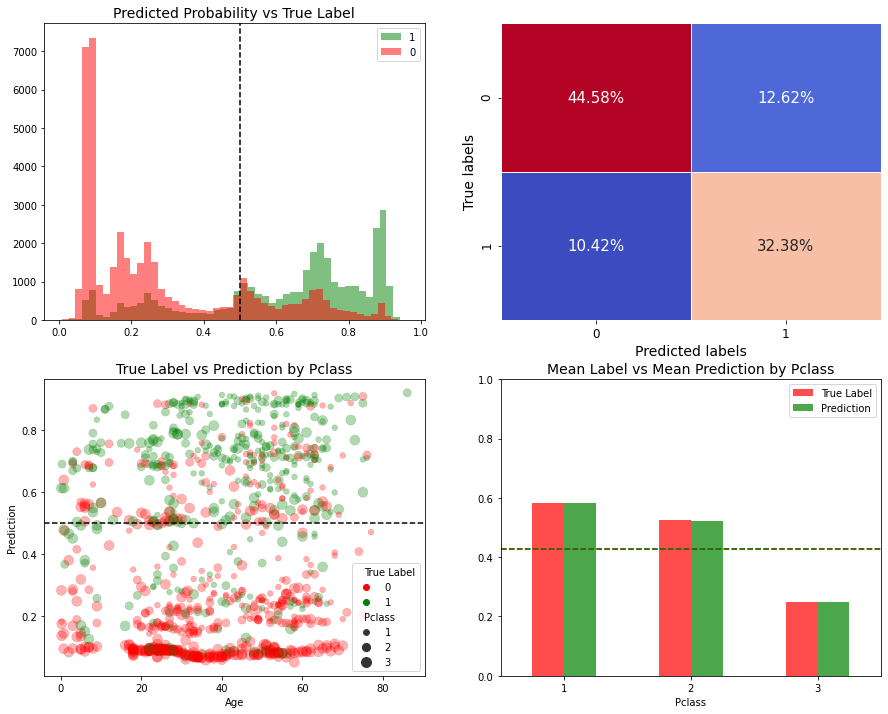

In [12]:
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')

# Classic features

In [14]:
class NumFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['fam_size'] = X_tr['Parch'] + X_tr['SibSp'] + 1
        X_tr['famsize_class'] = X_tr['fam_size'] * X_tr['Pclass']
        return X_tr

    
class CatFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['Emb_Sex'] = X_tr['Sex'] + '_' + X_tr['Embarked']
        return X_tr
    
    
class IntFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['Class_Sex'] = X_tr['Sex_male'] * X_tr['Pclass']
        return X_tr

In [15]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True)), 
                     ('feats', NumFeats())])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('feats', CatFeats()),
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), ('feats', IntFeats()),
                      ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=16, min_samples_split=16))])

In [16]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True, imp_coef=True)

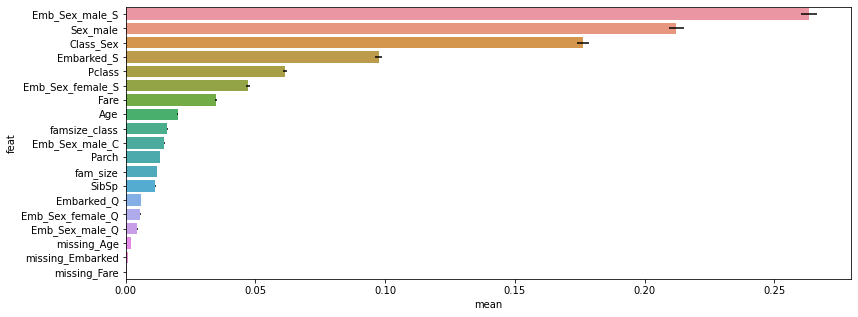

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


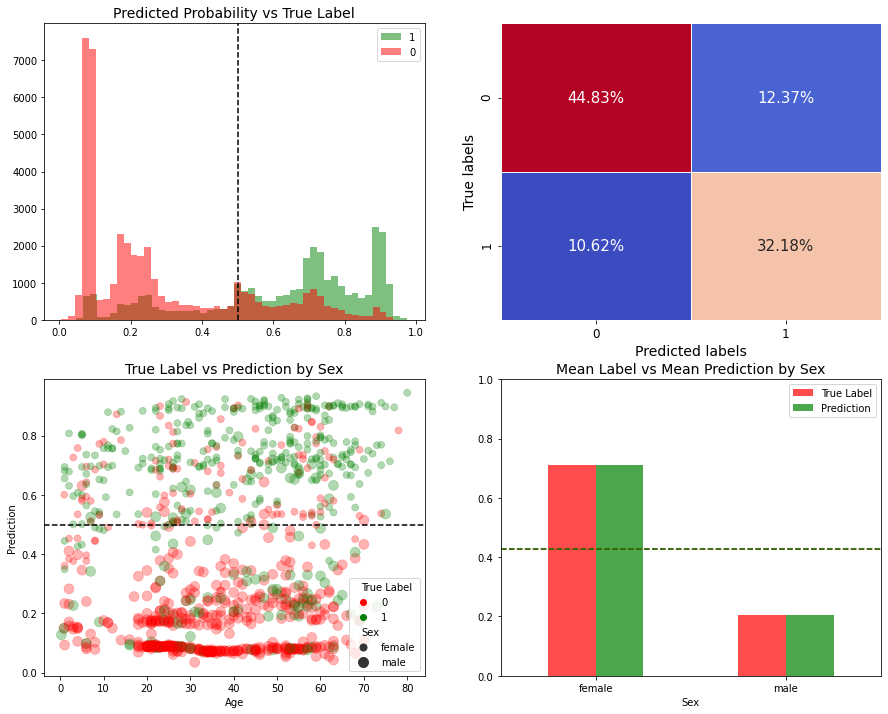

Accuracy score: 	0.7701
AUC ROC: 		0.84
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     42902
           1       0.72      0.75      0.74     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


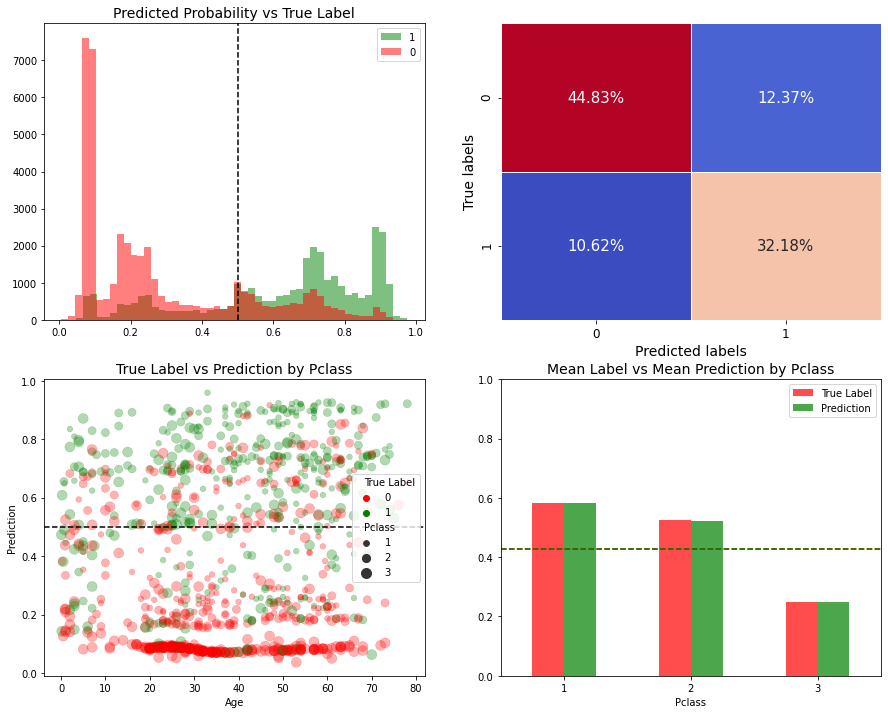

In [17]:
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')